###########################################################################<br>
\# This code is associated to the paper:<br>
\# <b>Provable bounds for noise-free expectation values computed from noisy samples</b><br>
\# (https://arxiv.org/abs/2312.00733)<br>
\# <br>
\# (C) Copyright IBM 2024.<br>
\# <br>
\# Any modifications or derivative works of this code must retain<br>
\# this copyright notice, and modified files need to carry a notice<br>
\# indicating that they have been altered from the originals.<br>
###########################################################################

# 40-qubit QAOA

QAOA for maxcut on random 3-regular graph with 40 nodes presented in https://arxiv.org/abs/2312.00733.

Original source of graph and circuit: 
- [1] Paper: "Large-scale quantum approximate optimization on non-planar graphs with machine learning noise mitigation", [arXiv:2307.14427](https://arxiv.org/abs/2307.14427) (2023). 
- [2] Repository: https://github.com/eggerdj/large_scale_qaoa

This notebook contains the code for:
- [Figure 4](#Figure-4)
- [Table 1](#Table-1)

In [1]:
import os.path
from zipfile import ZipFile
from tqdm import tqdm
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, qpy
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2, Batch

from qiskit_optimization.applications import Maxcut

import mthree

In [2]:
# optimal solution
opt_val = 56

# noise-free QAOA expectation values evaluated via lightcone optimization (cf. original source [1])
# p = 1, 2
noise_free_exp_vals = [41.5165, 45.2717]

In [3]:
# load graph
graph = json.load(open('./data/graph_7layers_8seed.json'))
problem = Maxcut(graph['Original graph'])
qp = problem.to_quadratic_program()

# define Maxcut objective
def objective(x):
    return qp.objective.evaluate([int(b) for b in reversed(x)])

In [4]:
# load circuits
with open('./data/circuits_40_qubits.qpy', 'rb') as f:
    qcs = qpy.load(f)

In [5]:
def unzip_and_load_results_file(filename):
    
    # unzip file
    if not os.path.isfile(f'results/{filename}'):
        print(f'unzip {filename}.zip... ', end='')
        with ZipFile(f'results/{filename}.zip', 'r') as zf:
            zf.extractall(path='results/')
            print('done!')

    # load file
    print(f'load  {filename}...     ', end='')
    with open(f'results/{filename}', 'r') as f:
        data = json.load(f)
    print('done!')
    return data

In [6]:
# instantiate Qiskit runtime service
# service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService(channel="ibm_quantum", instance='quantum-demonstrations/high-priority/qemcvar')

In [7]:
# select backend
backend = service.backend('ibm_sherbrooke')

# Initial layout and layer fidelity

The initial layout and layer fidelities can be evaluated using the following notebook:

https://github.com/qiskit-community/qiskit-device-benchmarking/blob/main/notebooks/layer_fidelity.ipynb

The notebook can be adjusted to determine the best 40 qubits and return the corresponding layer fidelities of pairwise CNOTs on qubits $(2*i, 2*i+1)$ as well as $(2*i+1, 2*i+2)$ for suitable $i$.

In [8]:
##########################################################################################
# insert initial layout from layer fidelity experiments
initial_layout = [ 50,  51,  36,  32,  31,  30,  17,  12,  11,  10,   9,   8,  16,
        26,  25,  24,  34,  43,  44,  45,  54,  64,  65,  66,  73,  85,
        86,  87,  93, 106, 107, 108, 112, 126, 125, 124, 123, 122, 121,
       120 ]
##########################################################################################

# Transpile circuits

In [9]:
# transpile circuits to backend
preset_manager = generate_preset_pass_manager(backend=backend, optimization_level=0, 
                                              initial_layout=initial_layout)
transpiled_qcs = preset_manager.run(qcs)    

# Run circuits

In [10]:
# uncomment to run circuits, otherwise, precomputed data will be loaded
# note that this will also overwrite the M3 measurement error calibrations
run_circuits = False

In [11]:
cals_file = f'results/m3_cals_{backend.name}.json'
if run_circuits:
    
    # submit circuits to backend
    shots = 100_000
    job_1 = None
    jobs_2 = []
    result_1 = None
    results_2 = []
    print('start jobs')
    with Batch(backend=backend) as batch:
    
        sampler = SamplerV2(session=batch)
        sampler.options.dynamical_decoupling.enable = True
        sampler.options.dynamical_decoupling.sequence_type = 'XY4'
        sampler.options.twirling.enable_gates = True
    
        # send job with 100k shots for p=1
        job_1 = sampler.run([transpiled_qcs[0]], shots=shots)
    
        # send 10 jobs with 10 circuits with 100k shots each to get a total of 10M shots
        for _ in range(10):
            jobs_2 += [sampler.run([transpiled_qcs[1]]*10, shots=shots)]
    
    # calibrate M3 readout error mitigation
    print('calibrate M3')
    shots_m3 = 10_000
    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(initial_layout, shots=shots_m3)
    
    # store M3 calibration data
    mit.cals_to_file(cals_file=cals_file)
    
    # get results
    print('get results')
    result_1 = job_1.result()
    for job in jobs_2:
        results_2 +=[job.result()]

    # get counts for p=1
    creg_1 = list(result_1[0].data.keys())[0]
    counts_1 = result_1[0].data[creg_1].get_counts()

    # save counts_1 to file
    with open('results/counts_1.json', 'w') as f:
        json.dump(counts_1, f)

    # get counts for p=2
    counts_2 = []
    for result in results_2:
        for r in result:
            creg_2 = list(r.data.keys())[0]
            counts_2 += [r.data[creg_2].get_counts()]

    # save counts_2 to file
    with open('results/counts_2.json', 'w') as f:
        json.dump(counts_2, f)

else:
    # unzip and load counts for p=1,2
    counts_1 = unzip_and_load_results_file('counts_1.json')
    counts_2 = unzip_and_load_results_file('counts_2.json')

load  counts_1.json...     done!
load  counts_2.json...     done!


In [12]:
# uncomment to run M3 measurement error mitigation, otherwise, precomputed data will be loaded
run_m3 = False

In [13]:
if run_m3:

    print('start error mitigation for p=1')

    # load calibrations from file
    mit = mthree.M3Mitigation()
    mit.cals_from_file(cals_file)
    max_iter = 25

    # apply M3 readout error mitigation
    res_1 = mit.apply_correction(counts_1, initial_layout, distance=5, method='iterative', max_iter=max_iter, details=True)
    quasis_1 = res_1[0]
    if res_1[1]['iterations'] == max_iter:
        print(f'Warning: max. iter. reached!')

    # save quasis_1 to file
    with open('results/quasis_1.json', 'w') as f:
        json.dump(quasis_1, f)

else:
    
    # unzip and load quasis for p=1
    quasis_1 = unzip_and_load_results_file('quasis_1.json')

load  quasis_1.json...     done!


In [14]:
if run_m3:

    print('start error mitigation for p=2')

    # load calibrations from file
    mit = mthree.M3Mitigation()
    mit.cals_from_file(cals_file)
    max_iter = 25
    
    # apply M3 readout error mitigation
    quasis_2 = []
    for cts in tqdm(counts_2):
        res_2 = mit.apply_correction(cts, initial_layout, distance=3, method='iterative', max_iter=max_iter, details=True)
        quasis_2 += [res_2[0]]
        if res_2[1]['iterations'] == max_iter:
            print(f'Warning: max. iter. reached!')

    # save quasis_2 to file
    with open('results/quasis_2.json', 'w') as f:
        json.dump(quasis_2, f)

else:
    # unzip and load quasis for p=2
    quasis_2 = unzip_and_load_results_file('quasis_2.json')

load  quasis_2.json...     done!


# Evaluate results

In [15]:
##########################################################################################
# derived from layer fidelity experiment
# July 30, 2024: ibm_sherbrooke
lf_1 = 0.7510
lf_2 = 0.7919
##########################################################################################

lf = lf_1 * lf_2
cnot_fidelity = lf**(1/39)
gamma_cnot = 1/cnot_fidelity**2
print('gamma_cnot:', gamma_cnot)

gamma_cnot: 1.0270080122917584


## Plot p=1 results with 100k shots

In [16]:
# extract probabilities and values
probs_1 = []
values_1 = []
for b, p in tqdm(quasis_1.items()):
    probs_1 += [p]
    values_1 += [objective(b)]
probs_1 = np.array(probs_1)
values_1 = np.array(values_1)
idx = np.argsort(values_1)
probs_1 = probs_1[idx]
values_1 = values_1[idx]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:23<00:00, 4288.74it/s]


In [17]:
# number comes from layer fidelity experiment
num_cnots_1 = qcs[0].count_ops()['cx']
sqrt_gamma_1 = gamma_cnot**(num_cnots_1/2)
alpha_1 = 1/sqrt_gamma_1

k = int(np.ceil(alpha_1*1e5))+1
cvar_gamma_1 = np.mean(values_1[-k:])

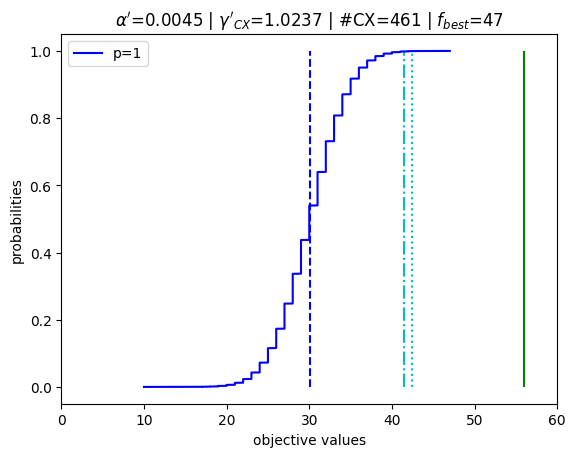

In [18]:
cum_probs_1 = np.cumsum(probs_1)
rev_cum_probs_1 = np.cumsum(probs_1[::-1])

j = 1
while (values_1[-j:]@probs_1[-j:])/rev_cum_probs_1[j-1] > noise_free_exp_vals[0]:
    j += 1
alpha_1_ = cum_probs_1[j-2]  # alpha' = fitted so CVaR matches expectation value

best_val_1 = np.max(values_1)

gamma_1_ = 1/alpha_1_**2
gamma_cnot_1_ = gamma_1_**(1/num_cnots_1)

mean_1 = values_1 @ probs_1

plt.title(rf"$\alpha'$={np.round(alpha_1_, decimals=4)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_1_, decimals=4)} | #CX={num_cnots_1} | $f_{{best}}$={int(best_val_1)}")

plt.vlines(opt_val, 0, 1, 'g')
plt.vlines(noise_free_exp_vals[0], 0, 1, 'c', linestyles='-.')
plt.vlines(cvar_gamma_1, 0, 1, 'c', linestyles=':')
plt.plot(values_1, cum_probs_1, 'b', label=f'p={1}')
plt.vlines(mean_1, 0, 1, 'b', linestyles='--')

plt.xlim(0, 60)
plt.legend(loc='upper left')

plt.ylabel('probabilities')
plt.xlabel('objective values')

plt.show()

## Evaluate p=2 results with 10M shots

In [ ]:
probs_2 = []
values_2 = []
for q in tqdm(quasis_2):
    for b, p in q.items():
        probs_2 += [p]
        values_2 += [objective(b)]

 14%|████████████████▍                                                                                                    | 14/100 [05:16<32:54, 22.96s/it]

In [ ]:
probs_2 = np.array(probs_2) / len(quasis_2)
values_2 = np.array(values_2)
idx = np.argsort(values_2)
probs_2 = probs_2[idx]
values_2 = values_2[idx]

## Plot p=2 results with 10M shots

In [ ]:
# number comes from layer fidelity experiment
num_cnots_2 = qcs[1].count_ops()['cx']
sqrt_gamma_2 = gamma_cnot**(num_cnots_2/2)
alpha_2 = 1/sqrt_gamma_2

k = int(np.ceil(alpha_2*1e7))+1
cvar_gamma_2 = np.mean(values_2[-k:])

In [ ]:
cum_probs_2 = np.cumsum(probs_2)
rev_cum_probs_2 = np.cumsum(probs_2[::-1])

j = 1
while (values_2[-j:]@probs_2[-j:])/rev_cum_probs_2[j-1] > noise_free_exp_vals[1]:
    j += 1
alpha_2_ = cum_probs_2[j-2]

best_val_2 = np.max(values_2)
gamma_2_ = 1/alpha_2_**2
gamma_cnot_2_ = gamma_2_**(1/num_cnots_2)
mean_2 = values_2 @ probs_2

plt.title(rf"$\alpha'$={np.round(alpha_2_, decimals=4)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_2_, decimals=4)} | #CX={num_cnots_2} | $f_{{best}}$={int(best_val_2)}")
plt.vlines(opt_val, 0, 1, 'g')
plt.vlines(noise_free_exp_vals[1], 0, 1, 'c', linestyles='-.')
plt.vlines(cvar_gamma_2, 0, 1, 'c', linestyles=':')
plt.plot(values_2, cum_probs_2, 'b', label=f'p={2}')
plt.vlines(mean_2, 0, 1, 'b', linestyles='--')
plt.xlim(0, 60)
plt.legend(loc='upper left')
plt.ylabel('probabilities')
plt.xlabel('objective values')
plt.show()

# Figure 4

In [ ]:
plt.subplots(2,1)

# p = 1
plt.subplot(2,1,1)
plt.title(rf"$\alpha'$={np.round(alpha_1_, decimals=4)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_1_, decimals=4)} | #CX={num_cnots_1} | $f_{{best}}$={int(best_val_1)}")
plt.vlines(opt_val, 0, 1, 'g')
plt.vlines(noise_free_exp_vals[0], 0, 1, 'c', linestyles='-.')
plt.vlines(cvar_gamma_1, 0, 1, 'c', linestyles=':')
plt.plot(values_1, cum_probs_1, 'b', label=f'p={1}')
plt.vlines(mean_1, 0, 1, 'b', linestyles='--')
plt.xlim(0, 60)
plt.legend(loc='upper left')
plt.ylabel('probabilities')

# p = 2
plt.subplot(2,1,2)
plt.title(rf"$\alpha'$={np.round(alpha_2_, decimals=4)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_2_, decimals=4)} | #CX={num_cnots_2} | $f_{{best}}$={int(best_val_2)}")
plt.vlines(opt_val, 0, 1, 'g')
plt.vlines(noise_free_exp_vals[1], 0, 1, 'c', linestyles='-.')
plt.vlines(cvar_gamma_2, 0, 1, 'c', linestyles=':')
plt.plot(values_2, cum_probs_2, 'b', label=f'p={2}')
plt.vlines(mean_2, 0, 1, 'b', linestyles='--')
plt.xlim(0, 60)
plt.legend(loc='upper left')
plt.ylabel('probabilities')
plt.xlabel('objective values')

plt.tight_layout()
plt.savefig(f'results/figure_4_{backend.name}.pdf')
plt.show()

# Table 1

In [ ]:
def npr(x, d=3):
    return np.round(x, decimals=d)

print('==============================')
print('global optimum:  ', opt_val)
print('gamma_cnot:      ', npr(gamma_cnot, 4))
print('==============================')
print('p=1')
print('==============================')
print('noisy mean:      ', npr(mean_1))
print('noise-free mean: ', npr(noise_free_exp_vals[0]))
print('CVaR_alpha:      ', npr(cvar_gamma_1))
print('best sample:     ', best_val_1)
print('------------------------------')
print('#CNOTs:          ', npr(num_cnots_1, 4))
print('sqrt(gamma):     ', npr(sqrt_gamma_1))
print('alpha:           ', npr(alpha_1, 8))
print('alpha_prime:     ', npr(alpha_1_, 8))
print('gamma_cnot_prime:', npr(gamma_cnot_1_, 4))
print('==============================')
print('p=2')
print('==============================')
print('noisy mean:     ', npr(mean_2))
print('noise-free mean:', npr(noise_free_exp_vals[1]))
print('CVaR_alpha:     ', npr(cvar_gamma_2))
print('best sample:    ', best_val_2)
print('------------------------------')
print('#CNOTs:          ', npr(num_cnots_2, 4))
print('sqrt(gamma):     ', npr(sqrt_gamma_2))
print('alpha:           ', npr(alpha_2, 8))
print('alpha_prime:     ', npr(alpha_2_, 8))
print('gamma_cnot_prime:', npr(gamma_cnot_2_, 4))
print('==============================')